# 3D Printer DataSet


The following example is designed to show you how to process a more complex data set.
You will learn how to process a data set in CSV format using Python, get an overview of the data, manipulate the data and perform classifications.

Python has a very good library for importing data from a data set: <b>pandas</b></br>
If it is not installed, it can be easily installed via:</br></br>

pip install pandas </br></br>


### Importing data:

In [2]:
import pandas as pd
data = pd.read_csv("data.csv", sep = ",")

### Let's get information about the content:

In [ ]:
data.info()

The data set is rather small, so we can also display the entire data set:

In [ ]:
data

Data can easily be manipulated. Here, for example, layer height and strain are multiplied by 100:

In [5]:
data.layer_height = data.layer_height*100
data.elongation = data.elongation*100

Let's display the first entries to check:

In [ ]:
data.head()

It is not so easy to process strings with ML algorithms, so let's reformat the dataset a little.
Define the material as 0 if it is ‘abs’ and as 1 if it is ‘pla’.

In [7]:
##Detailed procedure
templist = []
for entry in data.material:
    if entry == "abs": 
        templist.append(0)
    else: 
        templist.append(1)
data.material = templist

#Shortcut, does exactly the same:
#data.material = [0 if each == "abs" else 1 for each in data.material]

Now define the infill_pattern as 0 if it is ‘grid’ and as 1 if it is ‘honeycomb’.

In [ ]:
data

Separate input and output parameters:

In [10]:
y_data = data.material.values
x_data = data.drop(["material"],axis=1)

In [11]:
absm = data[data.material == 0]
pla = data[data.material == 1]

In [12]:
absm.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,2.0,8,90,0,220,60,40,0,0,25,18,120.0
1,2.0,7,90,1,225,65,40,0,25,32,16,140.0
2,2.0,1,80,0,230,70,40,0,50,40,8,80.0
3,2.0,4,70,1,240,75,40,0,75,68,10,50.0
4,2.0,6,90,0,250,80,40,0,100,92,5,70.0


Let's try to display various parameters 1:1 as a scatter plot. This way, we can quickly assess whether a correlation can be identified.<br>
matplotlib is very well suited for 2D data:

In [13]:
import matplotlib.pyplot as plt

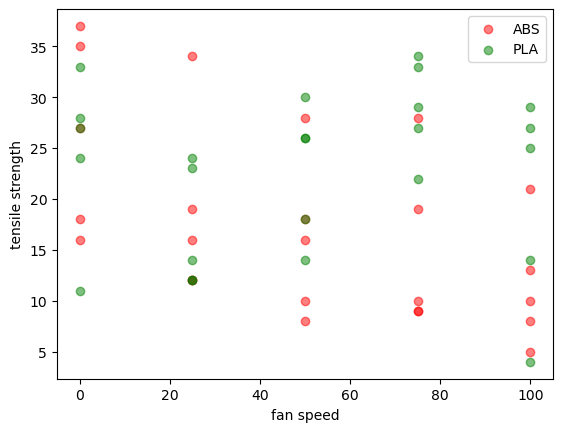

In [14]:
#Create individual scatter plots: We want to plot the tensile strength over the fan speed.
#Description of the parameters: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
#First for abs
plt.scatter(absm.fan_speed,absm.tension_strenght,color="red",label="ABS",alpha= 0.5)
#now for pla
plt.scatter(pla.fan_speed,pla.tension_strenght,color="green",label="PLA",alpha= 0.5)
plt.xlabel("fan speed")
plt.ylabel("tensile strength")
plt.legend()
plt.show()

There seems to be no correlation here.
Next, try plotting the roughness over the layer thickness.

What do you notice?

### 3D data plotting

There is a toolkit for matplotlib that makes it easy to create 3D scatter plots.
As an example, we plot the infill density on the x-axis, the wall thickness on the y-axis and the tensile strength on the z-axis:


<IPython.core.display.Javascript object>


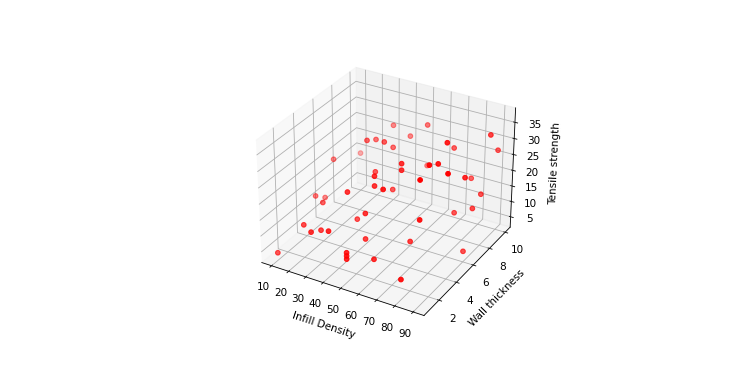

In [29]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

x = data.infill_density
y = data.wall_thickness
z = data.tension_strenght

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Infill Density')
ax.set_ylabel('Wall thickness')
ax.set_zlabel('Tensile strength')


plt.show()

## Task
In the 3D example, try to distinguish between the materials as well:

<IPython.core.display.Javascript object>


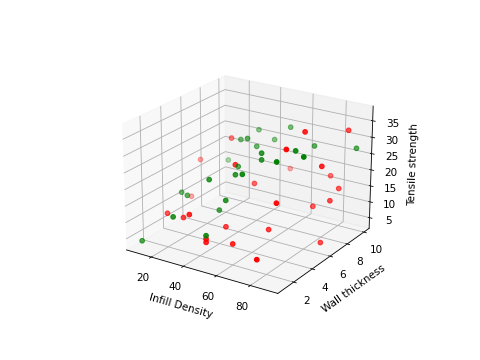

A faster method of finding correlations is to create a correlation matrix:

In [ ]:
#Note that the number 3 in the code indicates the number of digits after the decimal point for each cell.
correlation = data.corr()
correlation.style.background_gradient(cmap='coolwarm').format(precision=3)

At a glance, you can see all the features compared to each other with a pair plot. Be patient, it takes a while...

In [ ]:
%matplotlib inline

import seaborn as sns

sns.pairplot(data)

Selected parameters can also be plotted:

In [ ]:
 sns.pairplot(data,vars=["fan_speed", "nozzle_temperature"])

The type of display (diag_kind) and a distinguishing feature (hue) can also be passed:

In [ ]:
 sns.pairplot(data,vars=["fan_speed", "nozzle_temperature"], diag_kind="kde",hue="material")

## Task:

Which parameters would you choose to be able to identify the material? 
<ol>
<li>
Use the correlation matrix and the pair plot to find an approach.</li>
<li>Try to create a simple k-nearest neighbour (k-NN) classifier.</li> 
</ol>

In [ ]:
# Prepare data

#First, define the paramter 'material' as y-values:
y_data = data.material.values

#Now remove the material and all unimportant parameters, add all parameters without correlation to the material:
x_data = data.drop(["material","...","...","...","..."],axis=1)

### Normalization
In general, the algorithms work with numerical values between 0 and 1. Therefore, the remaining data must be scaled.
<br>This can be done manually:

In [ ]:
import numpy as np

print(x_data.head())
# Normalisation, i.e. bringing data into a range between 0 and 1
x_norm = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data))
print(x_norm.head())

### ...or use a tool! Attention: execute cell under the task again!

In [ ]:
from sklearn.preprocessing import MinMaxScaler

print(x_data.head())
mm = MinMaxScaler()
x_norm = mm.fit_transform(x_data)
print(x_norm)

### We need training and test data.
 These can be easily generated using train_test_split from the sklearn toolbox.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_norm,y_data,test_size = 0.3,random_state=1)

In [ ]:
#Now to the actual KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3) # n_neighbors = k, Let's start with three neighbours.
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
print(" {} nn score: {} ".format(3, knn.score(x_test,y_test)))


## Task:
Now investigate whether it improves with an increasing number of neighbours!

<ul>
    <li>What are you observing?</li>
    <li>Up to which size of k does it make sense?</li>
    <li>Why?</li>
</ul>